# Data augmentation
by uramoon@kw.ac.kr<br>

훈련 데이터가 부족한 경우 훈련 데이터를 늘려봅시다.<br>
본 노트북은 MNIST에서 99% 이상의 정확도를 보이는 간단한 CNN 모델을 사용합니다.

모델 출처: [MNIST: Simple CNN keras (Accuracy : 0.99)=>Top 1%](https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1/notebook) (<a href="https://raw.githubusercontent.com/ronreiter/interactive-tutorials/master/LICENSE">Apache 2.0 License</a>)

상단 메뉴 런타임 - 런타임 유형 변경에서 **GPU**를 선택하고 진행하세요.

## 이미지 변환 함수 (PNG -> 정규화된 이차원 배열)
일차원 배열을 입력받는 MLP와 달리 CNN은 **이차원 이미지**를 입력으로 받습니다.

In [ ]:
# image_prepare(파일이름)으로 호출하면 정규화된 단일채널 (흑백) 이차원 배열을 반환합니다.
# 지난 주에 제공한 코드는 (784,) 형태의 배열 반환, 여기에서는 (28, 28, 1) 형태의 배열 반환
# 코드를 이해할 필요는 없습니다.

import numpy as np
from PIL import Image, ImageFilter

def image_prepare(argv):
    """
    This function returns the pixel values.
    The imput is a png file location.
    """
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (255))  # creates white canvas of 28x28 pixels

    if width > height:  # check which dimension is bigger
        # Width is bigger. Width becomes 20 pixels.
        nheight = int(round((20.0 / width * height), 0))  # resize height according to ratio width
        if (nheight == 0):  # rare case but minimum is 1 pixel
            nheight = 1
            # resize and sharpen
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))  # calculate horizontal position
        newImage.paste(img, (4, wtop))  # paste resized image on white canvas
    else:
        # Height is bigger. Heigth becomes 20 pixels.
        nwidth = int(round((20.0 / height * width), 0))  # resize width according to ratio height
        if (nwidth == 0):  # rare case but minimum is 1 pixel
            nwidth = 1
            # resize and sharpen
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))  # caculate vertical pozition
        newImage.paste(img, (wleft, 4))  # paste resized image on white canvas

    # newImage.save("sample.png

    tv = list(newImage.getdata())  # get pixel values

    # normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [(255 - x) * 1.0 / 255.0 for x in tv]
    
    return np.array(tva).reshape(28, 28, 1)

## 우리가 만든 PNG 파일 준비하기
Pics.zip 파일을 Colab에 업로드한 후 진행합니다.

In [ ]:
# 디렉토리 만들기: our_mnist/0, our_mnist/1, ..., our_mnist/9
# 0에는 0에 해당하는 그림들이, ..., 9에는 9에 해당하는 그림들이 저장될 것입니다.

import os

os.mkdir('our_mnist')
for i in range(10):
  os.mkdir(f'our_mnist/{i}')

In [ ]:
# Pics.zip 압축풀기
!unzip Pics.zip
!rm Pics.zip

Archive:  Pics.zip
  inflating: 2010200054UA__.zip      
  inflating: 2010203001UA__.zip      
  inflating: 2010203011UA__img.zip   
  inflating: 2010203043UA_.zip       
  inflating: 2010203050UA_.zip       
  inflating: 2010203066UA__KW_MNIST.zip  
  inflating: 2010722043UA_mnist.zip  
  inflating: 2010726045UA_.zip       
  inflating: 2010726065UA_.zip       
  inflating: 2010726070UA_pics.zip   
  inflating: 2010726072UA__dataset.zip  
  inflating: 2010742014UA_.zip       
  inflating: 2010803003UA_.zip       
  inflating: 2017203053UA_.zip       
  inflating: 2017203076UA_.zip       
  inflating: 2018203008UA_.zip       
  inflating: 2018203012UA_.zip       
  inflating: 2018203016UA_.zip       
  inflating: 2018203022UA_.zip       
  inflating: 2018203031UA_.zip       
  inflating: 2018203035UA_.zip       
  inflating: 2018603027UA_.zip       
  inflating: 2018603039UA.zip        
  inflating: 2019204048UA.zip        
  inflating: 2019603016UA.zip        
  inflating: 2019603038U

In [ ]:
# 여러분이 제출한 모든 zip 파일을 열어 각 그림을 적절한 폴더에 학번_숫자.png로 저장합니다.
# 이해하지 않아도 됩니다.

from pathlib import Path
import zipfile

# 현재 디렉토리의 모든 파일 검사
for filename in os.listdir('.'):
  # zip 파일에 대해
  if filename.endswith('.zip'):
    # 학번 저장
    prefix = filename[:9]

    # zip 열기
    zipdata = zipfile.ZipFile(filename)
    zipinfos = zipdata.infolist()

    # 압축된 파일 하나씩 검사하기
    for zipinfo in zipinfos:
      if zipinfo.filename.endswith('.png'):
        # 경로 제외하기
        zippedFilename = Path(zipinfo.filename).stem + '.png'
        # 숫자 인식
        digit = zippedFilename[0]
        # 학번_ 붙이기
        zipinfo.filename = prefix + '_' + zippedFilename
        # 압축 풀기
        zipdata.extract(zipinfo, f'our_mnist/{digit}')

## TODO 1: 우리 그림 무작위로 그려보기
our_mnist 하위 디렉토리 (0, 1, ..., 9)에서 무작위로 하나씩 그려봅시다.<br>
(19학번까지는 훈련 데이터, 20학번부터는 테스트 데이터로 사용됩니다.)

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47548 (\N{HANGUL SYLLABLE RIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


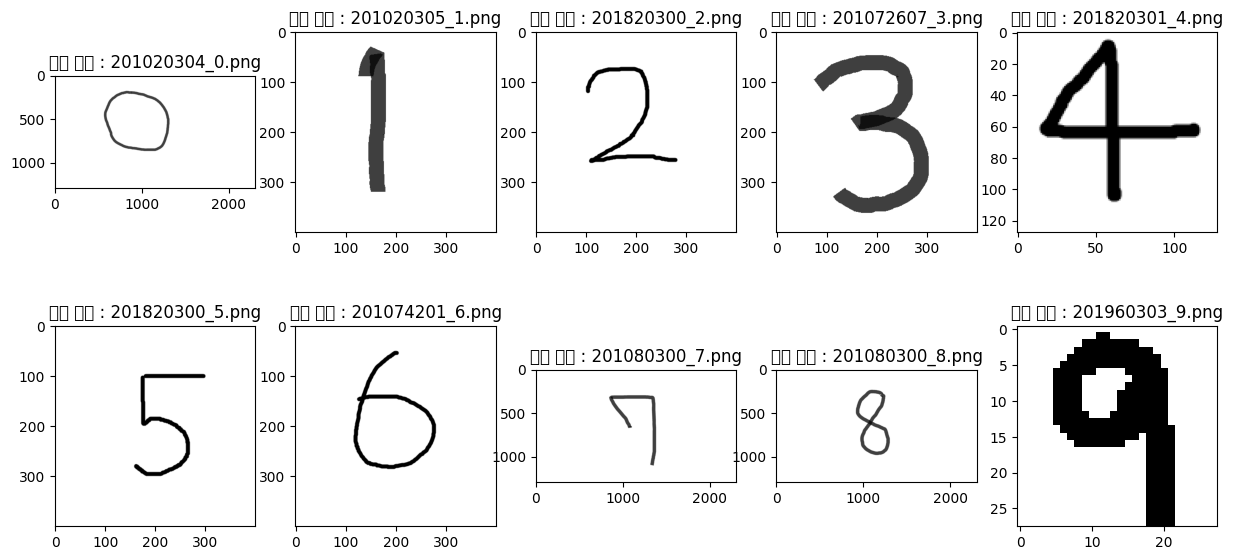

In [ ]:
# PNG 파일을 그립니다.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

plt.figure(figsize=(15, 7))
for i in range(10):
  target_dir = f'our_mnist/{i}' #TODO: 대상 디렉토리 이름을 쓰세요.
  rand_file = random.choice(os.listdir(target_dir))
  img = mpimg.imread(os.path.join(target_dir, rand_file))
  plt.subplot(2, 5, i+1) # 행은 두 개, 열은 다섯 개, 1로 시작하는 인덱스 기재
  plt.imshow(img)
  # TODO: 파일이름을 그림 제목으로 달아보세요.
  plt.title("그림 제목 : " + rand_file)
plt.show()

## 우리가 그린 그림으로 훈련/테스트 데이터셋 만들기
2020 미만 학번: 훈련 / 2020 이상 학번: 테스트

In [ ]:
# 이해하지 않아도 됩니다.

our_train_images = []
our_train_labels = []

our_test_images = []
our_test_labels = []

for i in range(10):
  for filename in os.listdir(f'our_mnist/{i}/'):    
    if filename < '2020':
      our_train_images.append(image_prepare(f'our_mnist/{i}/' + filename))
      our_train_labels.append(i)  
    else:
      our_test_images.append(image_prepare(f'our_mnist/{i}/' + filename))
      our_test_labels.append(i)  

our_train_images = np.asarray(our_train_images)
our_train_labels = np.asarray(our_train_labels)
our_test_images = np.asarray(our_test_images)
our_test_labels = np.asarray(our_test_labels)


print(f"train : {our_train_images.shape} {our_train_labels.shape}")
print(f"test : {our_test_images.shape} {our_test_labels.shape}")

train : (230, 28, 28, 1) (230,)
test : (70, 28, 28, 1) (70,)


## TODO 2: 우리가 만든 데이터셋 살펴보기
아래 코드를 실행해보고 물음에 답하세요.

Q1: 훈련 이미지의 모양을 어떻게 해석할 수 있을까요? <br>
A1: 훈련 이미지의 갯수는 230개이고 행과 열이 28인 이차원 배열 이다.<br>

Q2: 현재 훈련 레이블에 적합한 loss 함수는 무엇일까요? <br>
A2: 훈련 레이블의 모양이 (230, ) 이므로 index만 저장되어 있다. 따라서 loss함수 내부에서 label을 자동으로 변환해주는 sparse_categorical_crossentropy 를 사용해야 한다. <br>


### 복습 
1. categorical_crossentropy: 지난 시간에 사용한 함수로 정답 (label)이 5인 경우  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]와 같이 **label을 변환**해야 한다.
2. sparse_categorical_crossentropy: 정답 (label)이 5인 경우 5를 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]로 해석하여 loss를 계산하므로 **label을 변환할 필요가 없다.** (5를 봤을 때 5번째 인덱스의 출력은 1이고, 나머지는 0으로 해석)



In [ ]:
print(f'훈련 이미지 모양: {our_train_images.shape}')
print(f'훈련 레이블 내용: {our_train_labels}')

훈련 이미지 모양: (230, 28, 28, 1)
훈련 레이블 내용: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9]


## 훈련 데이터 무작위로 순서 바꾸기 (중요)
검증 데이터로 훈련 데이터의 20%를 사용하는 경우 훈련 데이터의 마지막 20%가 검증 데이터로 사용되는데 이렇게 되면 0부터 7까지로만 훈련하고, 8과 9가 검증 데이터로 활용되어 제대로 학습되지 않습니다. (훈련에 검증 데이터가 사용되지 않아 8과 9를 학습할 수 없음) 이를 방지하기 위해 훈련 데이터를 무작위로 섞습니다. (그림과 정답을 같은 순서로 섞어야 합니다.)

In [ ]:
# 이미지와 레이블을 동일한 순서로 섞습니다.

idx = np.random.permutation(len(our_train_images))
our_train_images, our_train_labels = our_train_images[idx], our_train_labels[idx]

In [ ]:
# 그림도 레이블과 동일한 순서로 섞였습니다.
print(f'순서를 섞은 후의 훈련 레이블 내용: {our_train_labels}')

순서를 섞은 후의 훈련 레이블 내용: [3 1 3 8 0 9 6 7 7 9 6 0 3 0 4 6 9 5 6 7 2 7 7 0 2 3 7 3 3 3 8 3 5 8 4 0 8
 0 3 6 1 5 5 1 7 8 8 3 7 0 0 7 4 2 1 5 8 4 4 9 2 1 5 8 1 1 7 9 7 6 6 4 8 3
 7 9 0 6 6 4 1 9 5 5 9 9 3 2 0 4 6 8 6 6 9 4 2 5 9 5 7 1 3 9 9 8 6 1 4 2 6
 3 3 6 4 4 0 3 7 7 5 2 5 1 2 0 2 0 8 6 9 1 3 2 2 8 7 3 9 9 1 1 4 7 6 2 2 2
 5 2 0 7 8 1 0 7 5 1 1 3 8 5 8 5 9 1 9 6 7 4 5 4 1 4 6 1 5 0 4 4 2 0 7 2 8
 5 4 2 2 0 8 1 3 3 0 9 5 9 0 8 8 4 3 6 4 7 0 7 5 8 6 1 2 9 6 8 2 9 8 2 9 6
 3 5 0 0 4 5 4 1]


## TODO 3: 모델 정의
MNIST에서 99% 이상의 정확도를 달성할 수 있는 모델입니다.<br>
입력층과 출력층 및 loss 함수만 기재하세요.


In [ ]:
# 나중에 모델을 초기화할 때도 사용합니다.
from keras import models
from keras import layers

model = models.Sequential()

# MLP에서는 (784,)였으나 CNN에서는 ...
model.add(layers.Input(shape=(28, 28, 1)))

model.add(layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=256, kernel_size = (3,3), activation="relu"))    
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))   

# 출력층 모양은 MLP와 동일합니다.
model.add(layers.Dense(10, activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

## 모델 훈련
우리가 만든 훈련데이터로 훈련해 봅니다.

In [ ]:
from keras.callbacks import EarlyStopping

epochs = 10000
es = EarlyStopping(patience=10, restore_best_weights=True)

model.fit(our_train_images, our_train_labels, epochs=epochs, callbacks=es, validation_split=0.2)

Epoch 1/10000
6/6 [==============================] - 16s 159ms/step - loss: 2.3095 - accuracy: 0.0652 - val_loss: 2.2980 - val_accuracy: 0.0870
Epoch 2/10000
6/6 [==============================] - 0s 12ms/step - loss: 2.2944 - accuracy: 0.1250 - val_loss: 2.2782 - val_accuracy: 0.1087
Epoch 3/10000
6/6 [==============================] - 0s 12ms/step - loss: 2.1976 - accuracy: 0.2011 - val_loss: 2.0482 - val_accuracy: 0.3478
Epoch 4/10000
6/6 [==============================] - 0s 12ms/step - loss: 1.7467 - accuracy: 0.4674 - val_loss: 1.5328 - val_accuracy: 0.4783
Epoch 5/10000
6/6 [==============================] - 0s 16ms/step - loss: 1.3602 - accuracy: 0.5163 - val_loss: 1.2830 - val_accuracy: 0.4783
Epoch 6/10000
6/6 [==============================] - 0s 14ms/step - loss: 0.9972 - accuracy: 0.6848 - val_loss: 1.0183 - val_accuracy: 0.6304
Epoch 7/10000
6/6 [==============================] - 0s 14ms/step - loss: 0.7198 - accuracy: 0.7609 - val_loss: 0.9836 - val_accuracy: 0.6087
Epoc

## TODO 4: 모델 평가
우리가 만든 테스트 데이터로 평가해 봅시다.

In [ ]:
score = model.evaluate(our_test_images, our_test_labels, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.781090497970581
Test accuracy: 0.7571428418159485


## TODO 5: ImageDataGenerator 설정
모델의 성능을 높이기 위해 더 많은 훈련 데이터가 필요해 보입니다.<br>
새로 그리는 것 대신 여러분의 그림에 변형을 가해 새로운 그림을 생성할 것입니다.<br>
다음 항목들을 참고하여 아래의 코드를 완성하세요.

1. 이미지를 최대 15도까지 무작위로 회전시키기
2. 이미지를 가로로 최대 10% 움직이기 
3. 이미지를 세로로 최대 10% 움직이기
4. 숫자 이미지를 위, 아래로 뒤집는 것을 허용해도 될까요? 
5. 숫자 이미지를 왼쪽, 오른쪽으로 뒤집는 것을 허용해도 될까요? 

Hint: https://keras.io/ko/preprocessing/image/

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(   
    rotation_range=15,
    width_shift_range=10,
    height_shift_range=10,
    horizontal_flip=0,
    vertical_flip=0)

## TODO 6: Image 생성해보기
우선 훈련 데이터의 첫 번째 그림을 그려봅시다.

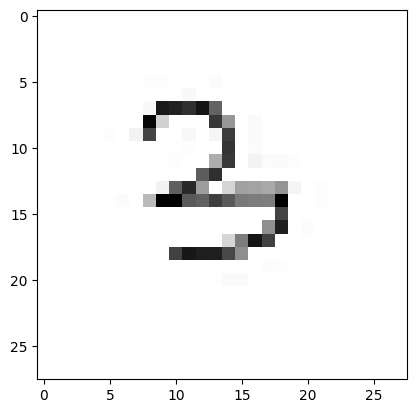

In [ ]:
import matplotlib.pyplot as plt

first_img = our_train_images[0] #TODO: 훈련 데이터의 첫 번째 그림 가져오기
digit = first_img.reshape((28, 28)) #TODO: 그릴 때에는 (28, 28, 1)을 (28, 28)로 reshape하세요.
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

TODO 5에서 만든 datagen으로 다섯 장의 새 그림을 만들어봅시다.<br>
다양한 이미지가 정상적으로 그려지지 않는다면 datagen 만들 때 실수한 것은 아닌지 확인해보세요. <br> (<1인 실수와 >=1인 정수 기재 시 의미가 달라지는 옵션들이 있습니다.)

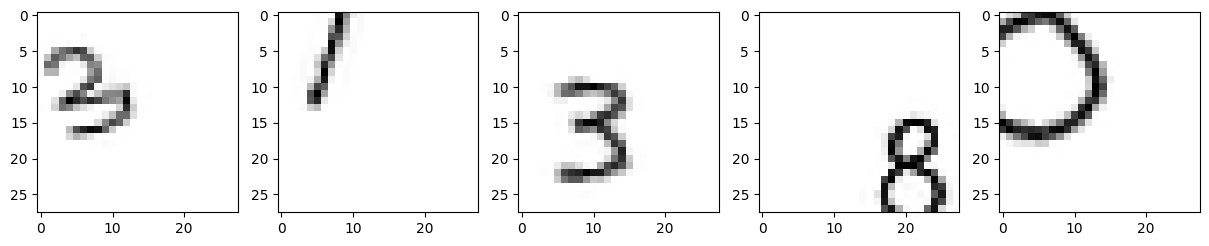

In [ ]:
plt.figure(figsize=(15, 4))
for i in range(5):
  new_img = datagen.random_transform(our_train_images[i]) # random_transform 함수에 첫 번째 그림 입력하여 새 그림 생성
  plt.subplot(1, 5, i+1) # 행 하나, 열 다섯 개, 1로 시작하는 인덱스
  plt.imshow(new_img.reshape((28, 28)), cmap=plt.cm.binary)
plt.show()

## TODO 7: 훈련 데이터 100배 늘리기
한 장의 훈련 이미지로 100장씩 생성해 봅시다.

In [ ]:
# 빈 배열 만들기
augmented_train_images = np.empty(shape=(our_train_images.shape[0] * 100, 28, 28, 1)) #TODO: 훈련 데이터가 100배 늘어나면 이미지의 모양은?
augmented_train_labels = np.empty(shape=(our_train_labels.shape[0] * 100)) #TODO: 훈련 데이터가 100배 늘어나면 레이블의 모양은?

# 배열 채우기
for i in range(len(our_train_images)):
  image = our_train_images[i] #TODO: 원본 이미지 지정
  label = our_train_labels[i] #TODO: 이미지의 답안 지정
  for j in range(100):
    augmented_train_images[i*100 + j] = datagen.random_transform(image) #TODO: datagen으로 생성한 이미지
    augmented_train_labels[i*100 + j] = label #TODO: 새로 생성한 이미지의 레이블

In [ ]:
print(f'원본 이미지 모양: {our_train_images.shape}')
print(f'증강 이미지 모양: {augmented_train_images.shape}')

원본 이미지 모양: (230, 28, 28, 1)
증강 이미지 모양: (23000, 28, 28, 1)


## TODO 8: 증강한 훈련 데이터의 순서 섞기

In [ ]:
#TODO: 순서를 섞어 보세요.
#Hint: TODO 2 아래 내용 참고

idx = np.random.permutation(len(augmented_train_images))
augmented_train_images, augmented_train_labels = augmented_train_images[idx], augmented_train_labels[idx]

## TODO 9: 모델 다시 정의하고 증강 데이터로 훈련하기
TODO 3의 코드를 다시 실행해서 모델을 초기화하고 아래 코드로 훈련합니다.

In [ ]:
# TODO 3 코드를 먼저 실행하여 모델을 초기화한 후 실행하세요.
from keras.callbacks import EarlyStopping

epochs = 10000
batch_size = 128

# 검증 데이터에서 100% 정확도를 달성한 이후에도 계속 훈련하는 것을 방지하기 위해 val_loss 대신 val_accuracy 사용
es = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

# 증강한 훈련 데이터를 사용합니다.
model.fit(augmented_train_images, augmented_train_labels, batch_size=batch_size, epochs=epochs, callbacks=es, validation_split=0.2)

Epoch 1/10000
144/144 [==============================] - 4s 20ms/step - loss: 1.1748 - accuracy: 0.6176 - val_loss: 0.5513 - val_accuracy: 0.8096
Epoch 2/10000
144/144 [==============================] - 2s 14ms/step - loss: 0.3829 - accuracy: 0.8765 - val_loss: 0.3095 - val_accuracy: 0.8941
Epoch 3/10000
144/144 [==============================] - 2s 13ms/step - loss: 0.2197 - accuracy: 0.9293 - val_loss: 0.2070 - val_accuracy: 0.9320
Epoch 4/10000
144/144 [==============================] - 2s 12ms/step - loss: 0.1453 - accuracy: 0.9532 - val_loss: 0.1445 - val_accuracy: 0.9557
Epoch 5/10000
144/144 [==============================] - 2s 12ms/step - loss: 0.0986 - accuracy: 0.9693 - val_loss: 0.1165 - val_accuracy: 0.9641
Epoch 6/10000
144/144 [==============================] - 2s 12ms/step - loss: 0.0685 - accuracy: 0.9792 - val_loss: 0.0944 - val_accuracy: 0.9709
Epoch 7/10000
144/144 [==============================] - 2s 12ms/step - loss: 0.0612 - accuracy: 0.9828 - val_loss: 0.1169 -

## TODO 10: 증강 데이터로 훈련한 모델 테스트하기
우리가 직접 그린 그림만으로 훈련한 모델 (TODO 4)과 증강한 데이터로 훈련한 모델의 성능을 비교해 보세요.

In [ ]:
# TODO 4의 코드를 복사하여 붙여넣고 실행하세요.

score = model.evaluate(our_test_images, our_test_labels, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.06522591412067413
Test accuracy: 0.9714285731315613


## TODO 11: MNIST 불러와서 전처리하기
MNIST 데이터로 훈련한 모델은 우리가 직접 그린 그림을 잘 분류하지 못했습니다.<br>
그렇다면 우리가 직접 그린 그림으로 훈련한 모델은 MNIST 데이터를 잘 분류할까요?

In [ ]:
from keras.datasets import mnist

# MNIST 테스트 데이터 불러오기
_, (X_test, y_test) = mnist.load_data()

# Scale images to the [0, 1] range
X_test = X_test.astype("float32") / 255

# MLP를 사용할 때는 X_test가 (10000, 784)의 모양이었지만 [10000장의 이미지, 각 그림은 784개의 픽셀]
# 현재는 이차원 흑백 이미지를 처리하는 CNN을 사용하고 있습니다. 어떤 모양으로 만들어야 할까요?
# Make sure images have shape (28, 28, 1)
print(X_test.shape)
X_test = X_test.reshape((10000, 28, 28, 1))
print(X_test.shape)

11490434/11490434 [==============================] - 2s 0us/step
(10000, 28, 28)
(10000, 28, 28, 1)


## TODO 12: MNIST 테스트 데이터로 모델 평가
MNIST 데이터로 훈련하면 99% 이상의 정확도를 얻을 수 있지만 우리가 직접 그린 그림을 활용하여 훈련한 모델의 성능은 다음과 같습니다.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 6.55747652053833
Test accuracy: 0.7610999941825867


다음 노트북에서 MNIST와 우리가 그린 그림을 모두 잘 예측하는 모델을 만들어 봅시다.